# NLP Iniciativas Legislativas (IL)
**Objetivo general** 

Identificar atributos y clasificar iniciativas legislativas sobre Salud iniciadas en la Càmara de Diputados utilizando datos abiertos y tècnicas de Machine Learning:

**Observaciones**

Base: notebook 00-EDA-iniciativasleg_salud y 00_ANEXO_COMISION.

En base al EDA de Iniciativias Legislativas (IL):
* 100913 IL tal que con información de giro a comisión solo 98469 IL (98%) y con resultado de tratamiento solo 97967 IL (97%)
* Los atributos exp_senado , fecha, od_publicacion , dictamen_tipo   presentan más del 80% de valores nulos
* Características de IL:
	* Existen 4 tipos IL RESOLUCION (45%) , LEY(36%) , DECLARACION(18%) , MENSAJE(0,7%) , MENSAJE Y PROYECTO DE LEY (0,03%) predomina las tres primero tipos
	* 10525 (10%) IL pasaron  por comisiones con la palabra salud
	* Ver errores:  puede una IL DECLARACION , RESOLUCION O MENSAJE ser un proyecto que se convirtio en ley?
	* Se identificar IL con ruido, se consideramos el tipo y giro a comisiones para su tratamiento, tener en cuenta para analizar los movimientos
	* Ventana de tiempo: 
		* Desde 2008 a 2023 se observa un compartamiento fluctuante en cantidad de IL por año, aunque que tendería a decrecer
	* En cuanto a resultados, 6 posibles resultados: NO TUVO TRATAMIENTO NI DICTAMEN (NULOS 86%), APROBADO (13%), MEDIA SANCION(1%), SANCIONADO, RECHAZADO Y RETIRADO	



In [1]:
# Importar librerias
import os
import pandas as pd
import numpy as np
import pickle
import sweetviz as sv

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from matplotlib import colormaps

# Grafos
import networkx as nx
from pyvis.network import Network


# Procesamientao
from sklearn.preprocessing import MinMaxScaler

# Clustering

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram

# Configurar path
os.chdir('C:/iamas_datos2024/proyectos_parlamentarios/')
pd.set_option('display.max_colwidth', None)

C:\Users\Usuario\iamas_iniciativasleg_salud\myenv_IL\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 - Recolección de datos

**Iniciativas Legislativas - Diccionario de datos**

* proyecto_id: identificador único de registro.
* publicación_fecha: Fecha en que se publicara el proyecto, ya sea que fuera publicado en cualquier publicación del Congreso, o sin publicación, se registra el primer movimiento en Comisión o en Recinto.
* publicacion_id: identificador único de la publicación correspondiente. (ver dataset ‘Publicaciones’ [https://datos.hcdn.gob.ar/dataset/publicaciones/resource/9ef22cd7-b7d8-47a6-bbf3-79095d47275c] En proyectos iniciados en la Cámara de Senadores, este valor será nulo. También será nulo cuando el proyecto no tuviere publicación por ser iniciado en recinto o dictamen directo en comisión.
* camara_origen: Cámara donde se inició el expediente; Diputados o Senadores.
* expediente_diputados: Número, identificador y año del expediente.
* expediente_senado: Número, identificador y año del expediente, cuando el expediente se girara al Senado.
* proyecto_tipo: tipo de proyecto que puede ser de ley, de resolución o declaración.
* giro_a_comisiones: Cantidad de veces en que un proyecto(proyecto:id) fue girado a comisiònes.Última actualización de los metadatos Agosto 8, 2019 de la fuente de datos. Pero si se mergea con la fuente de proyectos se logra mergear con proyectos hasta el 2024-02-29.
* proyecto_girado_a_comisiones_SALUD: si es 1 paso por alguna comisión de SALUD, sino 0.
* cabecera: indica que es el expediente principal; si el valor fuera un identificador de expediente se refiere al expediente principal en el dictamen. Cuando el valor fuere nulo, puede que: a) no tuvo dictamen de comisión o b) tuvo dictamen exclusivamente sobre ese proyecto. Valores de identificador de expedientes enlazado al dataset ‘proyectos parlamentarios’ (https://datos.hcdn.gob.ar/dataset/proyectos-parlamentarios/resource/22b2d52c-7a0e-426bac0a-a3326c388ba6).
* dictamen_tipo: Tipo de dictamen resuelto por la comisión. Puede ser ‘Orden del Día’, ‘Dictamen Sin Nro.’, ‘Artículo 114’, ‘Artículo 204’. Si el valor es nulo, no existió dictamen.
* OD_numero: cuando se trate de una “Orden del día” el número de la misma.
* OD_publicacion: Corresponde a la fecha de publicación o sea impresión de la Orden del Día,comienza el plazo de las Observaciones.
* fecha: del último movimiento y/o resultado.
* resultado: resultado que tuvo el expediente en la Cámara de Diputados. Ultima actualización 11 de julio de 2019, 13:48 (UTC-03:00) pero cuando se mergee logramos 2023-12-07. Estados: NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN. RETIRADO. RECHAZADO. APROBADO. MEDIA SANCION. SANCIONADO. Ver por tipo de proyecto la relacion con los estados.
* es_ley = indica si el proyecto se convirtio en ley. Esta relacionada al tipo de proyecto.



In [17]:
# Pickle con los datos procesados de iniciativas legislativas
with open('proyecto_df.pkl', 'rb') as file:
    proyecto_df = pickle.load(file)
print("Proyectos: ", proyecto_df.shape)
proyecto_df.head(2)

Proyectos:  (100913, 19)


,id,proyecto_id,titulo,publicacion_fecha,publicacion_id,camara_origen,exp_diputados,exp_senado,tipo,giros_a_comisiones,proyecto_girado_a_comisiones_SALUD,expediente_id,cabecera,dictamen_tipo,od_numero,od_publicacion,fecha,resultado,es_ley
0,0,HCDN276217,PEDIDO DE INFORMES AL PODER EJECUTIVO SOBRE DIVERSAS CUESTIONES RELACIONADAS CON los programas nacionales de asistencia y acompañamiento a la niñez y juventud vulnerables.,2024-06-24,HCDN142TP080,Diputados,3297-D-2024,NaN,RESOLUCION,NaN,SIN COMISION ASOCIADA,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
1,1,HCDN276218,"EXPRESAR ADHESIÓN Al “Día Internacional de las Microempresas y las Pequeñas y Medianas Empresas - MiPyME -”, que se conmemora el 27 de junio de cada año.",2024-06-24,HCDN142TP080,Diputados,3294-D-2024,NaN,RESOLUCION,NaN,SIN COMISION ASOCIADA,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


**Tratamiento de datos faltantes**

In [18]:
# Controlar nulos
proyecto_df.isnull().mean().sort_values(ascending=False)


es_ley                                0.993638
exp_senado                            0.987435
fecha                                 0.861485
od_publicacion                        0.840348
cabecera                              0.836453
dictamen_tipo                         0.835343
expediente_id                         0.029193
resultado                             0.029193
od_numero                             0.029193
giros_a_comisiones                    0.024219
publicacion_id                        0.007056
proyecto_girado_a_comisiones_SALUD    0.000000
proyecto_id                           0.000000
tipo                                  0.000000
exp_diputados                         0.000000
camara_origen                         0.000000
publicacion_fecha                     0.000000
titulo                                0.000000
id                                    0.000000
dtype: float64

In [19]:
proyecto_df[['proyecto_id','publicacion_fecha','tipo','resultado','giros_a_comisiones','proyecto_girado_a_comisiones_SALUD','es_ley']].describe(include = 'all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
proyecto_id,100913,100913,HCDN276217,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
publicacion_fecha,100913,NaN,NaN,NaN,2015-11-27 02:13:32.160970240,2008-03-03 00:00:00,2012-03-07 00:00:00,2015-07-31 00:00:00,2019-09-19 00:00:00,2024-06-24 00:00:00,NaN
tipo,100913,5,RESOLUCION,45543,NaN,NaN,NaN,NaN,NaN,NaN,NaN
resultado,97967,6,NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN,83989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
giros_a_comisiones,98469.0,NaN,NaN,NaN,1.534747,1.0,1.0,1.0,2.0,8.0,0.788111
proyecto_girado_a_comisiones_SALUD,100913,3,OTRAS COMISIONES,87944,NaN,NaN,NaN,NaN,NaN,NaN,NaN
es_ley,642.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [20]:
# Limpieza de datos - 
clean_dic = {'giros_a_comisiones':0, 'resultado': 'DATO FALTANTE', 'es_ley':0}
proyecto_df = proyecto_df.fillna(clean_dic)
proyecto_df[['proyecto_id','publicacion_fecha','tipo','resultado','giros_a_comisiones','proyecto_girado_a_comisiones_SALUD','es_ley']].isnull().mean().sort_values(ascending=False)

proyecto_id                           0.0
publicacion_fecha                     0.0
tipo                                  0.0
resultado                             0.0
giros_a_comisiones                    0.0
proyecto_girado_a_comisiones_SALUD    0.0
es_ley                                0.0
dtype: float64

**EDA**

Text(0, 0.5, 'Cantidad de IL')

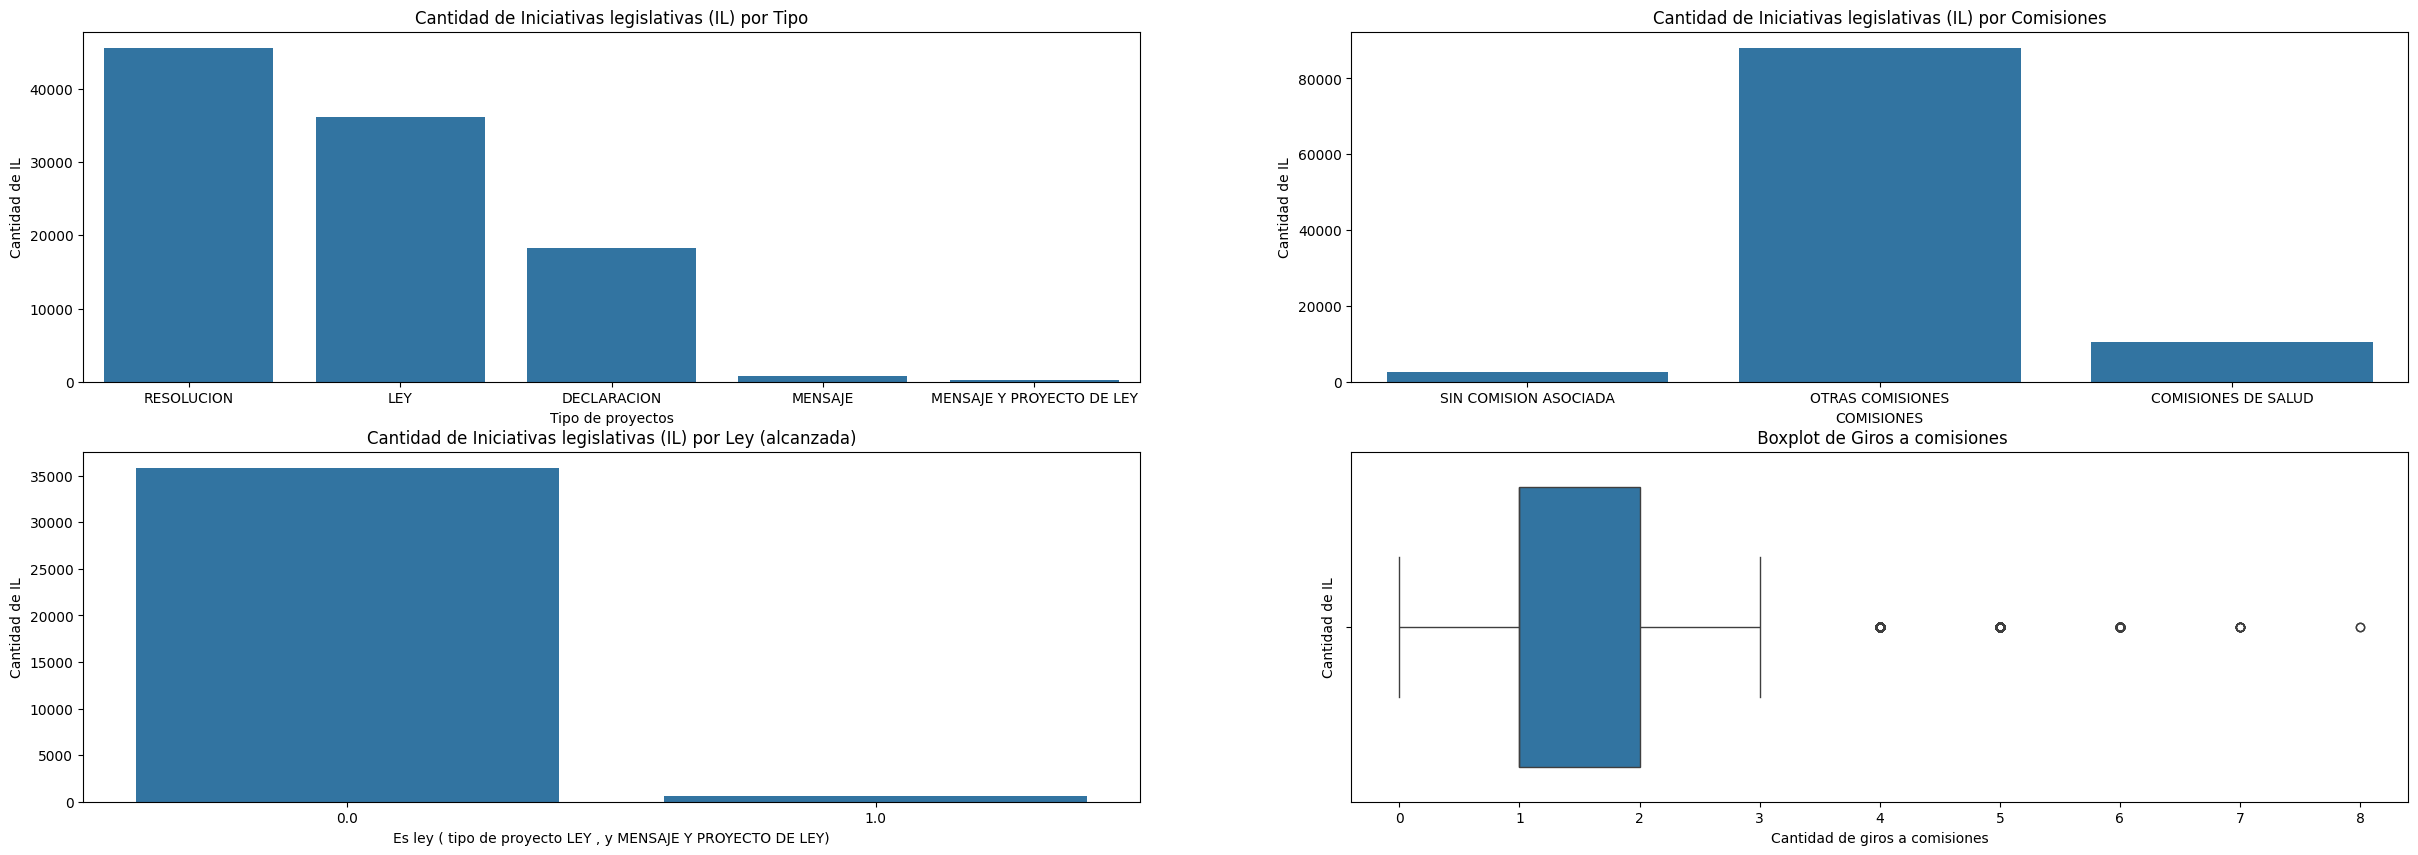

In [21]:
f, axs = plt.subplots(2, 2, figsize=(30, 10))
sns.countplot(x='tipo',  data=proyecto_df, ax = axs[0][0])
sns.countplot(x='proyecto_girado_a_comisiones_SALUD',  data=proyecto_df, ax = axs[0][1])
sns.countplot(x='es_ley',  data=proyecto_df[proyecto_df['tipo'].isin(['LEY','MENSAJE Y PROYECTO DE LEY'])], ax = axs[1][0])
sns.boxplot(data = proyecto_df, x = 'giros_a_comisiones', ax = axs[1][1] ) 
axs[0][0].set_title('Cantidad de Iniciativas legislativas (IL) por Tipo')
axs[0][0].set_ylabel("Cantidad de IL")
axs[0][0].set_xlabel("Tipo de proyectos")
axs[0][1].set_title('Cantidad de Iniciativas legislativas (IL) por Comisiones')
axs[0][1].set_xlabel("COMISIONES")
axs[0][1].set_ylabel("Cantidad de IL")
axs[1][0].set_title('Cantidad de Iniciativas legislativas (IL) por Ley (alcanzada)')
axs[1][0].set_xlabel("Es ley ( tipo de proyecto LEY , y MENSAJE Y PROYECTO DE LEY)")
axs[1][0].set_ylabel("Cantidad de IL")
axs[1][1].set_title(' Boxplot de Giros a comisiones')
axs[1][1].set_xlabel("Cantidad de giros a comisiones")
axs[1][1].set_ylabel("Cantidad de IL")


In [22]:
#  Datos útiles
# IL por año para analizar las ventana de tiemo
proyecto_df['año'] = proyecto_df['publicacion_fecha'].dt.year
#*100913 IL tal que con información de giro a comisión solo 98469 IL (98%) y con resultado de tratamiento solo 97967 IL (97%)
# Se considera todos los registros. Pero recordar que el 2024 no esta completo
ano_tipo_df = pd.pivot_table(proyecto_df, values=['proyecto_id'], index=['año','tipo','proyecto_girado_a_comisiones_SALUD','resultado'],
                       aggfunc={'proyecto_id': "count"}).reset_index()

In [23]:
ano_tipo_df.sort_values(by='proyecto_id', ascending = False)

,año,tipo,proyecto_girado_a_comisiones_SALUD,resultado,proyecto_id
152,2014,RESOLUCION,OTRAS COMISIONES,NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN,2612
133,2013,RESOLUCION,OTRAS COMISIONES,NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN,2580
114,2012,RESOLUCION,OTRAS COMISIONES,NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN,2531
144,2014,LEY,OTRAS COMISIONES,NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN,2524
69,2010,RESOLUCION,OTRAS COMISIONES,NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN,2427
...,...,...,...,...,...
57,2010,LEY,OTRAS COMISIONES,SANCIONADO,1
121,2013,LEY,COMISIONES DE SALUD,SANCIONADO,1
122,2013,LEY,OTRAS COMISIONES,DATO FALTANTE,1
54,2010,LEY,OTRAS COMISIONES,APROBADO,1


Text(0.5, 0, 'Año (publicación)')

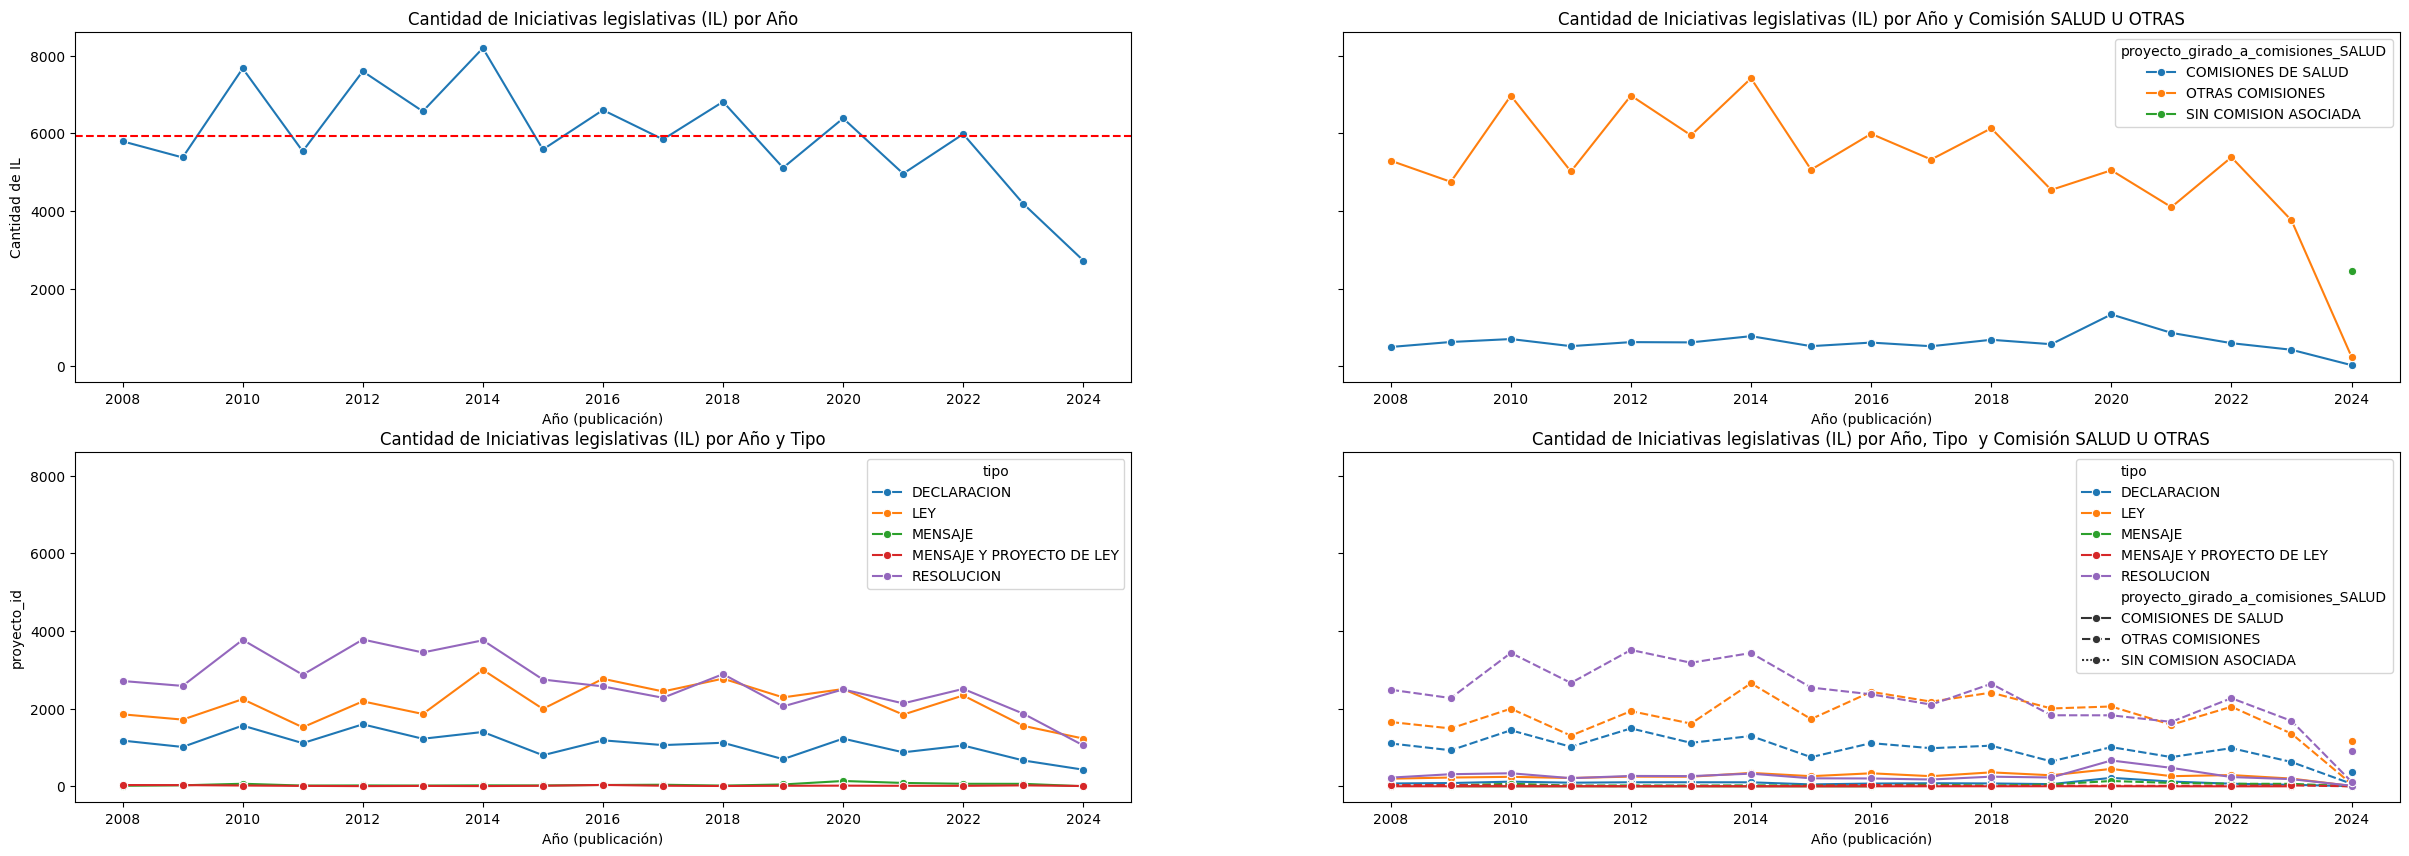

In [24]:
f, axs = plt.subplots(2, 2, figsize=(30, 10), sharey = True)
sns.lineplot(x=ano_tipo_df['año'], y=ano_tipo_df['proyecto_id'], estimator='sum', errorbar= None , linestyle='-', ax = axs[0][0], marker="o")
sns.lineplot(x=ano_tipo_df['año'], y=ano_tipo_df['proyecto_id'], estimator='sum',  hue = 'proyecto_girado_a_comisiones_SALUD', marker="o" ,data =ano_tipo_df,  errorbar= None , linestyle='-',ax = axs[0][1])
sns.lineplot(x=ano_tipo_df['año'], y=ano_tipo_df['proyecto_id'], estimator='sum',  hue = 'tipo', data =ano_tipo_df,  marker="o", errorbar= None , linestyle='-',ax = axs[1][0])
sns.lineplot(x=ano_tipo_df['año'], y=ano_tipo_df['proyecto_id'], estimator='sum',  hue = 'tipo', 
style="proyecto_girado_a_comisiones_SALUD", data =ano_tipo_df,  errorbar= None , linestyle='-',ax = axs[1][1], marker="o")

axs[0][0].axhline(y=ano_tipo_df.groupby('año')['proyecto_id'].sum().mean(), color='r', linestyle='--')
axs[0][0].set_title('Cantidad de Iniciativas legislativas (IL) por Año')
axs[0][0].set_xlabel("Año (publicación)")
axs[0][0].set_ylabel("Cantidad de IL")
axs[0][1].set_title('Cantidad de Iniciativas legislativas (IL) por Año y Comisión SALUD U OTRAS')
axs[0][1].set_xlabel("Año (publicación)")
axs[1][0].set_title('Cantidad de Iniciativas legislativas (IL) por Año y Tipo')
axs[1][0].set_xlabel("Año (publicación)")
axs[1][1].set_title('Cantidad de Iniciativas legislativas (IL) por Año, Tipo  y Comisión SALUD U OTRAS')
axs[1][1].set_xlabel("Año (publicación)")



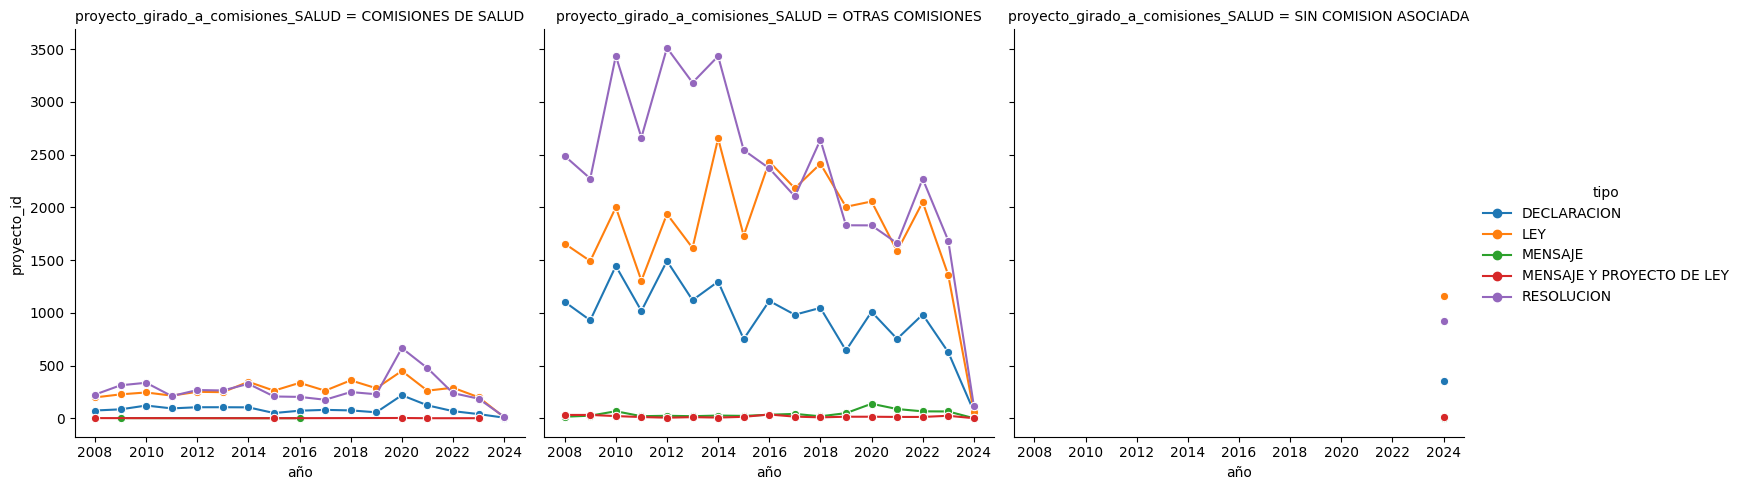

In [25]:
#100913 IL tal que con información de giro a comisión solo 98469 IL (98%) y con resultado de tratamiento solo 97967 IL (97%)
#ano_tipo_df
sns.relplot(
    data=ano_tipo_df, x="año", y="proyecto_id", col="proyecto_girado_a_comisiones_SALUD",
    hue="tipo",  kind="line", estimator = 'sum', errorbar= None, marker='o',
)

## 2 -Limpieza y preparación de los datos 

In [26]:
# Librerias para texto
#import gensim
import re
#from gensim.corpora import Dictionary
import nltk
import spacy

# https://pypi.org/project/textacy/
import textacy
import textacy.preprocessing as tprep


In [27]:
# Seleccionamos texto
texto_df = proyecto_df[['proyecto_id','titulo']]
texto_df.head()

,proyecto_id,titulo
0,HCDN276217,PEDIDO DE INFORMES AL PODER EJECUTIVO SOBRE DIVERSAS CUESTIONES RELACIONADAS CON los programas nacionales de asistencia y acompañamiento a la niñez y juventud vulnerables.
1,HCDN276218,"EXPRESAR ADHESIÓN Al “Día Internacional de las Microempresas y las Pequeñas y Medianas Empresas - MiPyME -”, que se conmemora el 27 de junio de cada año."
2,HCDN276210,inStitúyase el 24 de junio de cada año como “Día Nacional del Deporte Argentino”.
3,HCDN276226,SOLICITAR AL PODER EJECUTIVO DISPONGA LA REGLAMENTACIÓN DE LA LEY 27098 - RÉGIMEN DE PROMOCIÓN DE LOS CLUBES DE BARRIO Y DE PUEBLO -.
4,HCDN276224,"PEDIDO DE INFORMES VERBALES A La titular de la Administración Federal de Ingresos Públicos (AFIP), Florencia Lucila Misrahi, sobre la actuación del organismo en relación a las empresas tabacaleras."


Los títulos de los IL presentan entre 0 y 600 caracteres.

<Axes: >

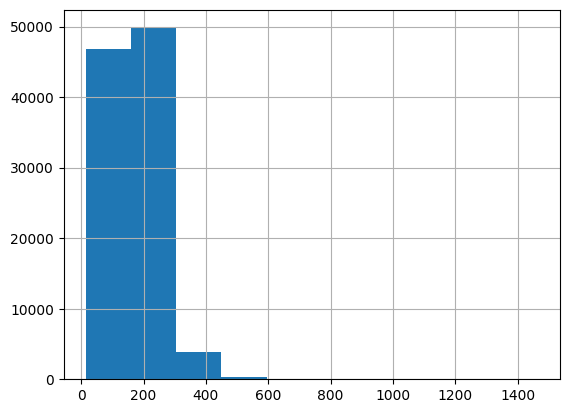

In [13]:
texto_df['titulo'].str.len().hist()

Entre 2 a 217 posibles palabras en titulo de proyecto. En promedio 27 palabras por titulo

<Axes: >

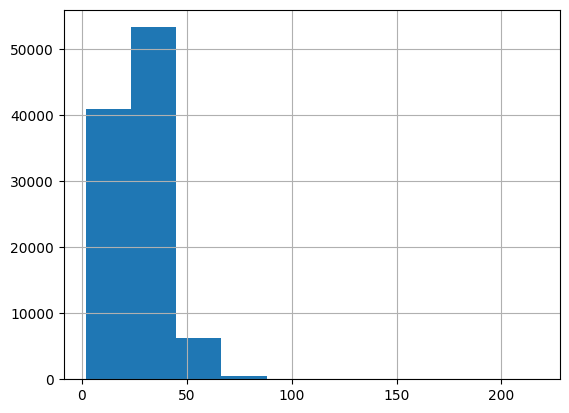

In [14]:
texto_df['titulo'].str.split().map(lambda x: len(x)).hist()

In [15]:
texto_df['titulo'].str.split().map(lambda x: len(x)).describe()

count    100913.000000
mean         27.041491
std          11.435643
min           2.000000
25%          19.000000
50%          26.000000
75%          34.000000
max         217.000000
Name: titulo, dtype: float64

Viendo como se distribuyen los titulos por tipo de proyecto (IL)

In [16]:
# Explorando por tipo de proyecto
proyecto_df['cant_palabras_aprox'] = proyecto_df['titulo'].str.split().map(lambda x: len(x))
pd.pivot_table(proyecto_df, values=['cant_palabras_aprox'], index=['tipo'],
                       aggfunc={'cant_palabras_aprox': ('mean',"min","max")}).reset_index()



tipo cant_palabras_aprox               
                                             max       mean min
0                DECLARACION                 105  28.952893   6
1                        LEY                 134  21.315586   2
2                    MENSAJE                  91  37.722146   6
3  MENSAJE Y PROYECTO DE LEY                 132  26.948805   2
4                 RESOLUCION                 217  30.650374   4

In [17]:
## Proyectos con titulos con dos palabras
proyecto_df.loc[proyecto_df['cant_palabras_aprox'] == 2, ['proyecto_id','titulo','tipo','giros_a_comisiones','año']]

,proyecto_id,titulo,tipo,giros_a_comisiones,año
1423,HCDN274094,ANTIMAFIA. REGIMEN.,LEY,0.0,2024
1676,HCDN273738,EQUINOTERAPIA. REGIMEN.,LEY,0.0,2024
2280,HCDN272960,EQUINOTERAPIA. REGIMEN.,LEY,0.0,2024
3686,HCDN270826,FINANCIAMIENTO EDUCATIVO.,MENSAJE Y PROYECTO DE LEY,2.0,2023
8110,HCDN263380,EQUINOTERAPIA. REGIMEN.,LEY,3.0,2022
11069,HCDN257458,EQUINOTERAPIA. REGIMEN.,LEY,3.0,2022
11640,HCDN256556,EQUINOTERAPIA. REGIMEN.,LEY,3.0,2022
12118,HCDN256091,CIBERPROTECCION. REGIMEN,LEY,4.0,2022
13025,HCDN254874,CONTROL POSLEGISLATIVO.,LEY,2.0,2021
13233,HCDN254457,EUTANASIA. REGIMEN.,LEY,4.0,2021


In [18]:
# Analizando por cantidad promedio de palabras por, año, tipo y girado a comisiones de salud
ano_tipo_df = pd.pivot_table(proyecto_df, values=['cant_palabras_aprox'], index=['año','tipo','proyecto_girado_a_comisiones_SALUD'],
                       aggfunc={'cant_palabras_aprox': "mean"}).reset_index()


In [19]:
ano_tipo_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
año,148.0,NaN,NaN,NaN,2016.27027,5.06904,2008.0,2012.0,2016.0,2021.0,2024.0
tipo,148,5,DECLARACION,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
proyecto_girado_a_comisiones_SALUD,148,3,OTRAS COMISIONES,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cant_palabras_aprox,148.0,NaN,NaN,NaN,27.450376,6.02862,12.0,22.232323,28.112605,30.762205,45.147059


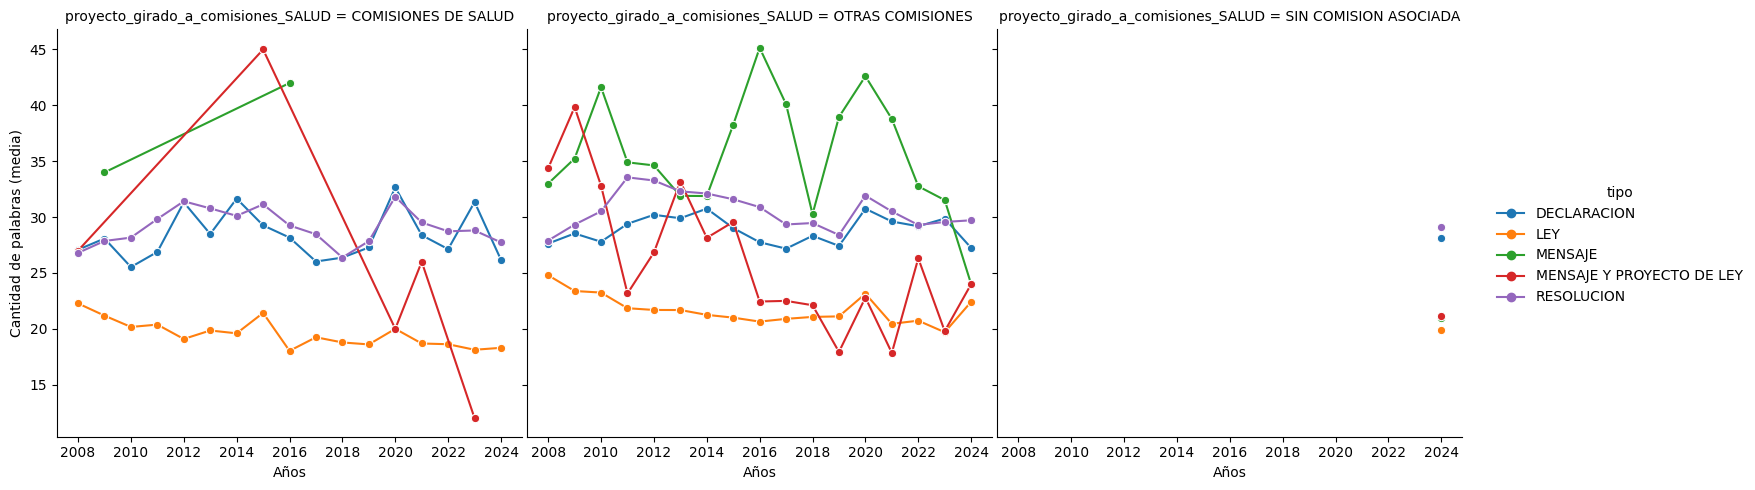

In [20]:
g = sns.relplot(
    data=ano_tipo_df, x="año", y="cant_palabras_aprox", col="proyecto_girado_a_comisiones_SALUD",
    hue="tipo",  kind="line", estimator = 'sum', errorbar= None, marker='o',
)

(g.set_axis_labels("Años", "Cantidad de palabras (media)")
  .tight_layout(w_pad=0))

Nos centraremos en IL por ley y exploraremos que pasa en salud. En promedio de palabra por titulo de proyecto de tipo LEY,  21 PALABRAS POR TITULO

## NLP para IL - proyectos de ley 
#### Preprocesamiento de textos

1. - Eliminación de ruido:

Este paso tiene como objetivo eliminar todos aquellos símbolos o caracteres que no aportan nada en el significado de las frases (ojo no confundir con las stop-words), como por ejemplo etiquetas HTML (para el caso del scraping), parseos de XML, JSON, etc.

2. - Tokenización:

Este paso tiene como objetivo dividir las cadenas de texto del documento en piezas más pequeñas o tokens.
Aunque la tokenización es el proceso de dividir grandes cadenas de texto en cadenas más pequeñas, se suele diferenciar la:

* Segmentation: Tarea de dividir grandes cadenas de texto en piezas más pequeñas como oraciones o párrafos.
* Tokenization: Tarea de dividir grandes cadenas de texto solo y exclusivamente en palabras.


3. - Normalización:

La normalización es una tarea que tiene como objetivo poner todo el texto en igualdad de condiciones:
* Convertir todo el texto en mayúscula o minúsculas
* Eliminar, puntos, comas, comillas, etc.
* Convertir los números a su equivalente a palabras
* Quitar las Stop-words
* etc.


TAREAS A REALIZAR:


* Transformar un texto en tokens
* Eliminar los tokens que son signos (puntuación, exclamación, etc.)
* Eliminar las palabras que tienen menos de 'N' caracteres
* Eliminar las palabras que son Stop Words
* Pasar el texto a minúsculas
* Lematización

In [21]:
# https://github.com/RicardoMoya/NLP_with_Python/blob/master/04_Preprocesamiento_de_textos_Normalizacion.ipynb

####GENERALES####
from spacy.lang.es.stop_words import STOP_WORDS
import spacy
nlp = spacy.load('es_core_news_sm')


####DOMINIO####
stopwords_dominio = ['numero','articulo','ley','expediente','codigo','ano','modificación']  
for word in stopwords_dominio:
    STOP_WORDS.add(word)

# Para limpiar simbolos
def limpieza_basica_texto(text):
    try: 
      
       # Normaliza los caracteres Unicode del texto en formas canónicas. 
       text = tprep.normalize.unicode(text) 
       # Elimina los acentos de cualquier carácter Unicode acentuado en el texto, ya sea reemplazándolos con equivalentes ASCII o eliminándolos por completo. 
       text = tprep.remove.accents(text)
       # Por tema de leyes y números 
       text = text.replace('.','') 
       # Elimine la puntuación del texto reemplazando todas las instancias de puntuación (o un subconjunto de la misma especificada por solamente) con espacios en blanco. 
       text = tprep.remove.punctuation(text) # ojo que lo reemplaza por espacio, por eso mejor normalize.whitespace al final
       ## Elimina los espacios
       #text = text.strip() 
       # Reemplza comillas simples y dobles a solo los equivalentes básicos de ASCII. 
       text = tprep.normalize.quotation_marks(text)
       # Reemplaza espacios respetando la división entre palabras 
       text = tprep.normalize.whitespace(text) 
       # Reemplaza  {}, square [], and/or round ()
       text = tprep.remove.brackets(text)
       # Reemplaza los números por la palabra 'numero'     
       text = tprep.replace.numbers(text,"numero")
    
    except:
        print("Hubo un error")
    
    return text

def get_tokens(text):
    """
    Función que dado un texto devuelve una lista con las palabras del texto no vacias
    """
    doc = nlp(text)
    return [word.text.strip() for word in doc if len(word.text.strip()) > 0]

def remove_punctuation(words):
    """
    Función que dada una lista de palabras, elimina los signos de puntuación
    """
    doc = spacy.tokens.doc.Doc(nlp.vocab, words=words)
    return [word.text for word in doc if not word.is_punct]

def remove_short_words(words, num_chars):
    """
    Función que dada una lista de palabras y un número mínimo de caracteres que tienen que tener
    las palabras, elimina todas las palabras que tengan menos caracteres que los indicados
    """
    return [word for word in words if len(word) > num_chars]

def remove_stop_words(words):
    """
    Función que dada una lista de palabras, elimina las Stop Words
    """
    doc = nlp("".join(words))
    #print(doc)
    return " ".join([word.text for word in doc if not word.is_stop])

def to_lowercase(words):
    """
    Función que dada una lista de palabras, las transforma a minúsculas
    """
    return [word.lower() for word in words]

def lemmatizer(words,  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Función que dada una lista de palabras, devuelve esa lista con el lema de cada una de esas palabras
    """
    doc = nlp(" ".join(words))
    #print([word.lemma_ if word.lemma_ not in ['-PRON-'] else '' for word in doc if word.pos_ in allowed_postags])
    return " ".join([word.lemma_ if word.lemma_ not in ['-PRON-'] else '' for word in doc if word.pos_ in allowed_postags])



def normalizar_viejo(text):
    """
    Dado un texto, devuelve el texto tokenizado y normalizado
    """
    
    words = get_tokens(text=text)
    words = to_lowercase(words)
    #words = remove_punctuation(words=words)
    #words = remove_short_words(words=words, num_chars=3)
    words = remove_stop_words(words)
    words = lemmatizer(words)
    return words

def normalizar(text):
    """
    Dado un texto, devuelve el texto tokenizado y normalizado
    """
    
    words = get_tokens(text=text)
    #print(words)
    words = to_lowercase(words)
    words = remove_punctuation(words=words)
    words = lemmatizer(words)
    #print(words)
    #words = remove_short_words(words=words, num_chars=3)
    words = remove_stop_words(words)
    return words


In [22]:
# Probando función
text = limpieza_basica_texto('EMERGENCIA LABORAL PARA EL PERSONAL DE LA ADMINISTRACIÓN PUBLICA NACIONAL 1.343 (VER)')
print('Texto original:','EMERGENCIA LABORAL PARA EL PERSONAL DE LA ADMINISTRACIÓN PUBLICA NACIONAL 1.343 (VER)')
print('Limpieza primera:',text)
print("Normalizado:",normalizar(text))
print("############################# Controlando errores de normalización")
doc = nlp(text)
print('NLP spacy:',doc)
print("Token sin stop word",[word.text for word in doc if not word.is_stop])
print("\n ** Controlando lematizador:",[(word.lemma_ , word.pos_) for word in doc] )
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
doc2 = nlp(" ".join([word.text for word in doc if not word.is_stop]))
print("\n ** Controlando lematizador doc2:",[(word.lemma_ , word.pos_) for word in doc2] )
print("\n ** Controlando lematizador con postag:"," ".join([word.lemma_ if word.lemma_ not in ['-PRON-'] else '' for word in doc if word.pos_ in allowed_postags]))
print([word.text for word in doc if not word.is_stop])

Texto original: EMERGENCIA LABORAL PARA EL PERSONAL DE LA ADMINISTRACIÓN PUBLICA NACIONAL 1.343 (VER)
Limpieza primera: EMERGENCIA LABORAL PARA EL PERSONAL DE LA ADMINISTRACION PUBLICA NACIONAL numero VER
Normalizado: emergencia laboral personal publicar nacional
############################# Controlando errores de normalización
NLP spacy: EMERGENCIA LABORAL PARA EL PERSONAL DE LA ADMINISTRACION PUBLICA NACIONAL numero VER
Token sin stop word ['EMERGENCIA', 'LABORAL', 'PERSONAL', 'ADMINISTRACION', 'PUBLICA', 'NACIONAL']

 ** Controlando lematizador: [('emergencia', 'NOUN'), ('laboral', 'ADJ'), ('PARA', 'ADP'), ('el', 'DET'), ('PERSONAL', 'PROPN'), ('DE', 'ADP'), ('el', 'DET'), ('administracion', 'NOUN'), ('publico', 'ADJ'), ('NACIONAL', 'PROPN'), ('numero', 'ADJ'), ('ver', 'VERB')]

 ** Controlando lematizador doc2: [('emergencia', 'NOUN'), ('laboral', 'ADJ'), ('PERSONAL', 'PROPN'), ('ADMINISTRACION', 'PROPN'), ('publicar', 'VERB'), ('NACIONAL', 'PROPN')]

 ** Controlando lematizador c

In [23]:
# Seleccionanos los texto - titilo IL de ley para 2010 a 2023 -- 31334
texto_df = proyecto_df.loc[ (proyecto_df['año']>2009) & (proyecto_df['año']<2024) & ( proyecto_df['tipo'] == 'LEY') , ('proyecto_id','titulo')]#sample(frac=0.001, replace=True, random_state=1)
texto_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31334 entries, 2724 to 89725
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   proyecto_id  31334 non-null  object
 1   titulo       31334 non-null  object
dtypes: object(2)
memory usage: 734.4+ KB


In [24]:
texto_df.head(2)

,proyecto_id,titulo
2724,HCDN272363,DECLARESE EL 2024 COMO AÑO DEL 140 ANIVERSARIO DE LA PROMULGACION DE LA LEY 1420 DE EDUCACION COMUN.
2730,HCDN272359,"FINANCIAMIENTO DE LOS PARTIDOS POLITICOS - LEY 26215 - Y CODIGO ELECTORAL NACIONAL - LEY 19945 -. MODIFICACIONES SOBRE CONTRATACION DE PUBLICIDAD Y BOLETA UNICA, RESPECTIVAMENTE."


In [25]:
# Normalización
texto_df['titulo normalizado'] = texto_df['titulo'].copy()
texto_df['titulo normalizado'] = texto_df['titulo normalizado'].apply(limpieza_basica_texto) # caracteres especiales
texto_df['titulo normalizado'] = texto_df['titulo normalizado'].apply(normalizar)


In [26]:
texto_df.head(10)

,proyecto_id,titulo,titulo normalizado
2724,HCDN272363,DECLARESE EL 2024 COMO AÑO DEL 140 ANIVERSARIO DE LA PROMULGACION DE LA LEY 1420 DE EDUCACION COMUN.,declaresar aniversario comun
2730,HCDN272359,"FINANCIAMIENTO DE LOS PARTIDOS POLITICOS - LEY 26215 - Y CODIGO ELECTORAL NACIONAL - LEY 19945 -. MODIFICACIONES SOBRE CONTRATACION DE PUBLICIDAD Y BOLETA UNICA, RESPECTIVAMENTE.",financiamiento partido politico electoral nacional modificación publicidad boleta unico respectivamente
2732,HCDN272360,EMERGENCIA LABORAL PARA EL PERSONAL DE LA ADMINISTRACION PUBLICA NACIONAL.,emergencia laboral personal publicar nacional
2733,HCDN272352,CODIGO PENAL DE LA NACION. MODIFICACION DE LOS ARTICULOS 155 Y 169 SOBRE DIFUSION DE CONTENIDO SEXUAL O EROTICO DE TERCEROS Y SIN AUTORIZACION.,penal contenido sexual erotico
2739,HCDN272353,REFORMA DEL ESTADO. DEROGACION Y MODIFICACION DE DIVERSAS LEYES Y DECRETOS.,reforma decreto
2741,HCDN272334,FONDO FEDERAL PARA EL DESARROLLO NACIONAL. CREACION.,fondo federal desarrollo
2743,HCDN272337,"DEMOCRATIZACION DE LA REPRESENTACION POLITICA, LA TRANSPARENCIA Y LA EQUIDAD ELECTORAL - LEY 26571 -. DEROGACION DEL TITULO II SOBRE ELECCIONES ""PRIMARIAS ABIERTAS, SIMULTANEAS Y OBLIGATORIAS"".",democratizacion politico transparencia equidad electoral titulo elección primario abierto simultanea obligatorio
2744,HCDN272335,ORGANICA DE LOS PARTIDOS POLITICOS - LEY 23298 -. MODIFICACIONES SOBRE PERSONERIA JURIDICO POLITICA,organico partido politico modificación personeria juridico politico
2746,HCDN272336,ZONA FRANCA PARA EL COMERCIO MINORISTA EN LA PROVINCIA DE SALTA. CREACION.,zona franco comercio minorista provincia salta creacion
2747,HCDN272331,"REGIMEN LEGAL DE LOS DECRETOS DE NECESIDAD Y URGENCIA LEY 26122. MODIFICACIONES, SOBRE INTEGRANTES Y FUNCIONAMIENTO DE LA COMISION BICAMERAL PERMANENTE DE TRAMITE LEGISLATIVO.",regimar legal decreto necesidad urgencia modificación integrante funcionamiento comision bicameral permanente tramite legislativo


In [27]:
import pickle
pickle.dump(texto_df, open('./texto_df_ley_1023.pkl', 'wb'))

In [28]:
texto_df['cant_token'] = texto_df['titulo'].str.split().map(lambda x: len(x))
texto_df['cant_token_normalizado'] = texto_df['titulo normalizado'].str.split().map(lambda x: len(x))


,count,mean,std,min,25%,50%,75%,max
cant_token,31334.0,21.078126,10.695903,2.0,14.0,19.0,27.0,125.0
cant_token_normalizado,31334.0,8.102860,4.385013,0.0,5.0,7.0,10.0,47.0


<Axes: >

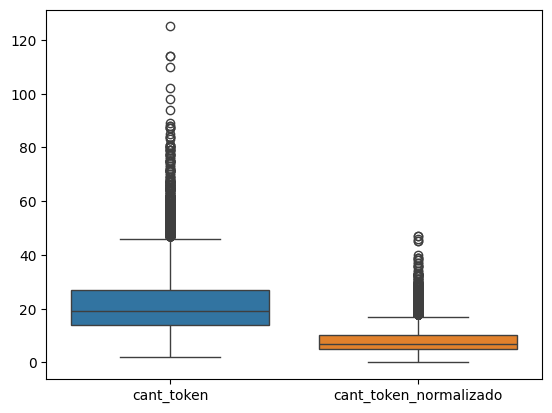

In [29]:
# Distribución
display(texto_df[['cant_token','cant_token_normalizado']].describe().T)
sns.boxplot(data=texto_df[['cant_token','cant_token_normalizado']])

Exploramos por tipo de proyecto ley, y resultado

In [30]:
pd.pivot_table(pd.merge(texto_df,proyecto_df[['proyecto_id','proyecto_girado_a_comisiones_SALUD','resultado','año']], how = 'inner',left_on = 'proyecto_id', right_on='proyecto_id' ), values=['cant_token','cant_token_normalizado'], index=['resultado'],
                       aggfunc={'cant_token': ('mean',"min","max"),'cant_token_normalizado': ('mean',"min","max")}).reset_index()

resultado cant_token                 \
                                                    max       mean min   
0                                   APROBADO         44  25.714286  16   
1                              DATO FALTANTE         48  18.775000   3   
2                              MEDIA SANCION         79  22.084525   2   
3  NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN        125  21.060385   2   
4                                   RETIRADO         34  34.000000  34   
5                                 SANCIONADO         44  20.548387   5   

  cant_token_normalizado                
                     max      mean min  
0                     21  9.714286   6  
1                     22  7.725000   2  
2                     38  8.639792   0  
3                     47  8.090150   0  
4                     11  9.500000   8  
5                     21  8.258065   3

In [31]:
# Para ver por años, resultado, girado a comision
ano_tipo_df = pd.pivot_table(pd.merge(texto_df,proyecto_df[['proyecto_id','proyecto_girado_a_comisiones_SALUD','resultado','año']], how = 'inner',left_on = 'proyecto_id', right_on='proyecto_id' ), values=['cant_token','cant_token_normalizado'], index=['año','proyecto_girado_a_comisiones_SALUD','resultado'],
                       aggfunc={'cant_token': "mean", 'cant_token_normalizado': 'mean'}).reset_index()
#ano_tipo_df

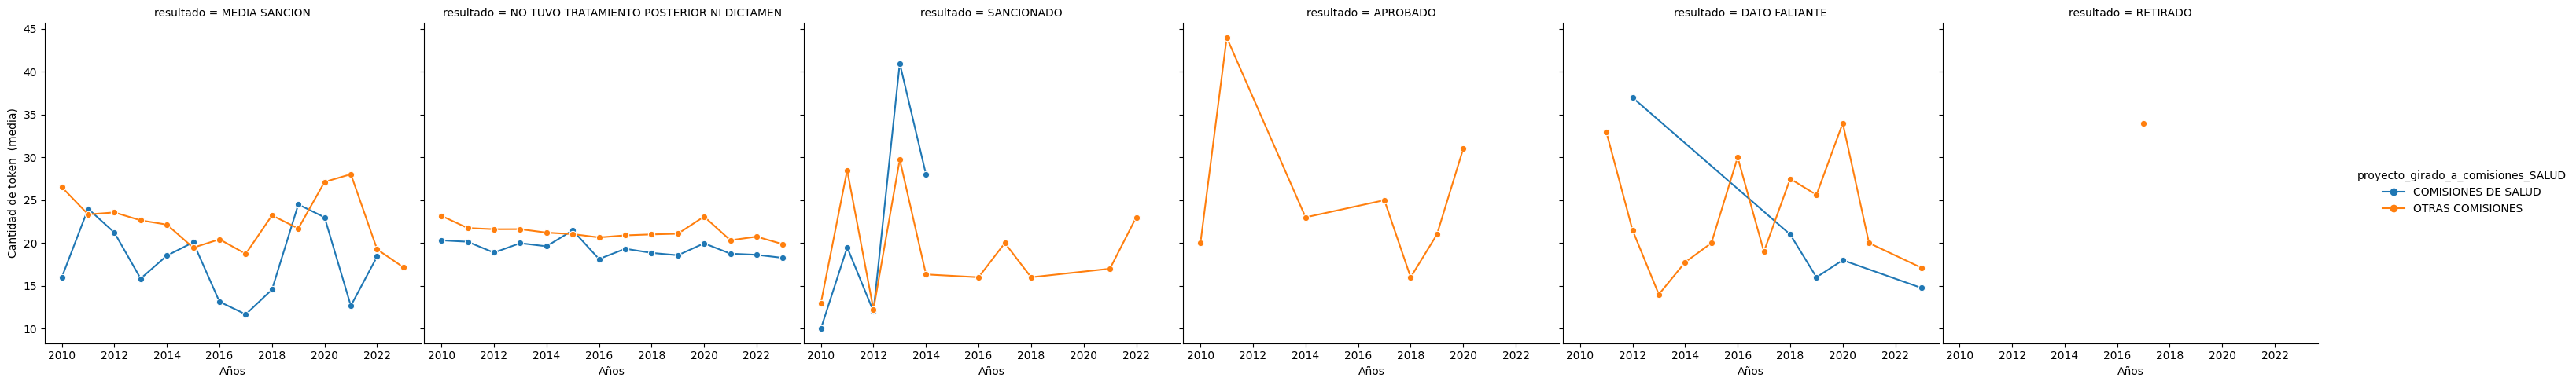

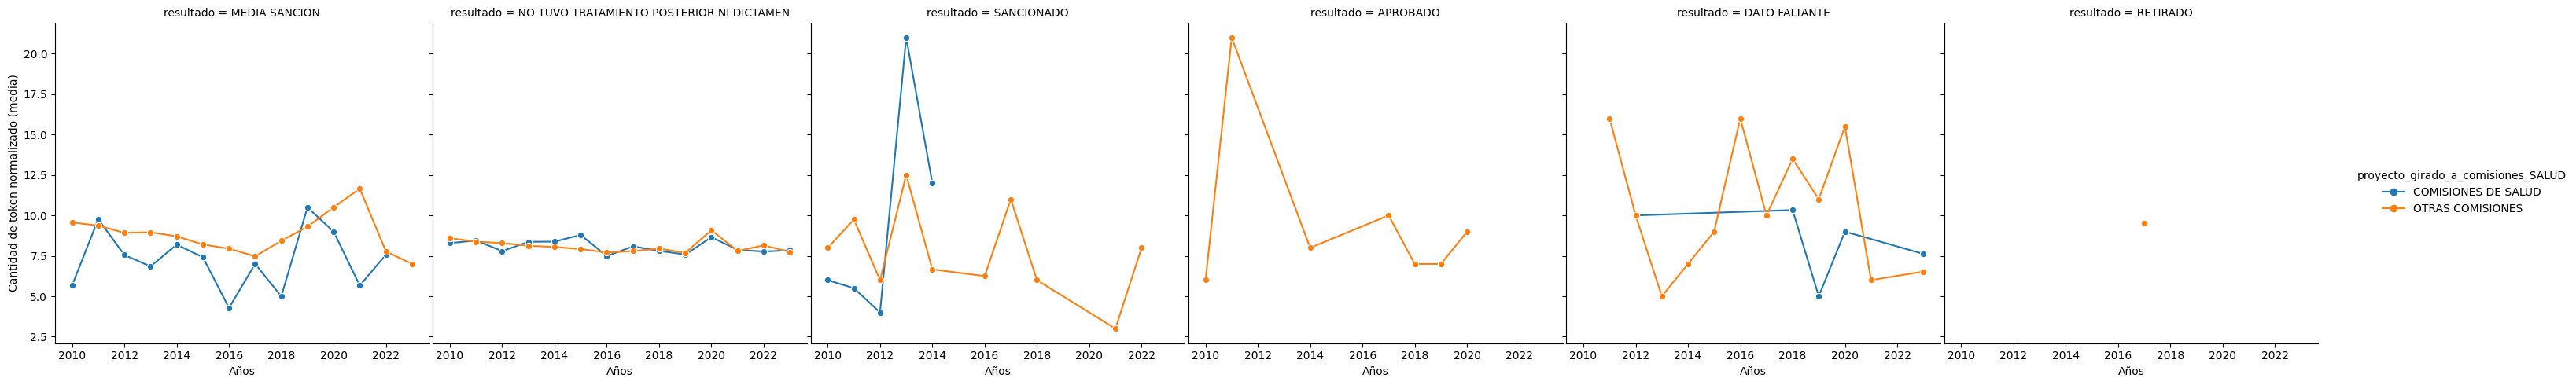

In [32]:
# Sin limpieza
g = sns.relplot(
    data=ano_tipo_df, x="año", y="cant_token", col="resultado",
    hue="proyecto_girado_a_comisiones_SALUD",  kind="line", estimator = 'sum', errorbar= None, marker='o',
)

(g.set_axis_labels("Años", "Cantidad de token  (media)")
  .tight_layout(w_pad=0))

# con limpieza
g = sns.relplot(
    data=ano_tipo_df, x="año", y="cant_token_normalizado", col="resultado",
    hue="proyecto_girado_a_comisiones_SALUD",  kind="line", estimator = 'sum', errorbar= None, marker='o',
)

(g.set_axis_labels("Años", "Cantidad de token normalizado (media)")
  .tight_layout(w_pad=0))

#### Creacción del diccionario y la bolsa de palabras (BoW)
En este punto tenemos que crear:
* Corpus tokenizado: "documents_tok"
* Diccionario: "dictionary"
* Corpus: "corpus' que es la bolsa de palabras de gensim

In [3]:
# https://github.com/RicardoMoya/NLP_with_Python/blob/master/21_Topic_Modeling_noticias.ipynb
# https://github.com/RicardoMoya/NLP_with_Python/blob/master/05_Bag_of_Words_BoW.ipynb

#import gensim
#import gensim.corpora as corpora
from pprint import pprint
#from gensim import corpora
from collections import defaultdict
from collections import Counter


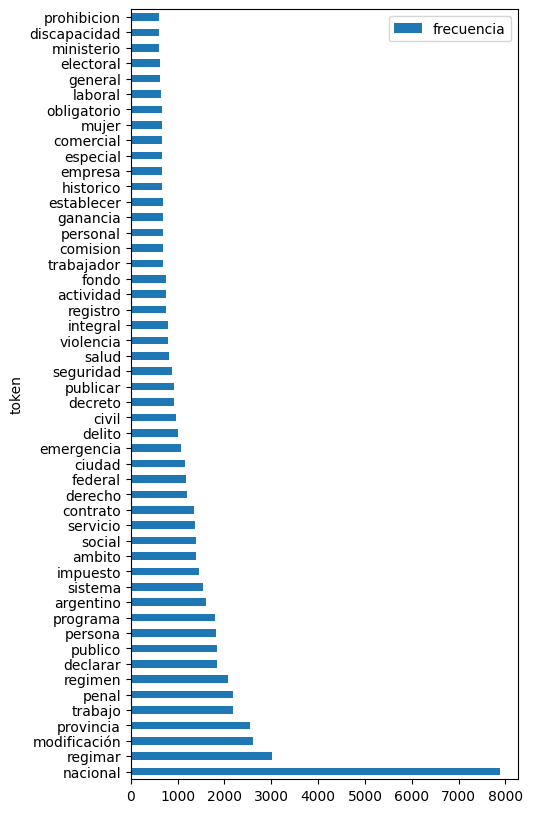

In [34]:
##################################PASOS DICCIONARIO########################
corpus_norm = list(texto_df['titulo normalizado'])
# Tokenizamos
documents_tok = [word.split() for word in corpus_norm]

# Creamos el diccionario (vocabulario)
frequency = defaultdict(int)
for doc in documents_tok:
    for token in doc:
        frequency[token] += 1

# Exploramos todas las palabras para limpiar mejor
counter = Counter(frequency)
ig, ax = plt.subplots(figsize=(5, 10))
ax = pd.DataFrame.from_records(counter.most_common(50), columns = ['token','frecuencia']).plot(kind='barh', x = 'token', ax=ax)


In [35]:
####GENERALES####
#from spacy.lang.es.stop_words import STOP_WORDS

####DOMINIO####
#stopwords_dominio = ['numero','articulo','ley','expediente','codigo','ano']  
#for word in stopwords_dominio:
#    STOP_WORDS.add(word)
    
#texto_df['titulo normalizado'] = texto_df['titulo normalizado'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))


In [30]:
# Lo guardamos de nuevo
#pickle.dump(texto_df, open('./texto_df_ley_1023.pkl', 'wb'))
texto_df = pickle.load(open('./texto_df_ley_1023.pkl', 'rb'))

In [31]:
texto_df.head(10)

,proyecto_id,titulo,titulo normalizado,cant_token,cant_token_normalizado
2724,HCDN272363,DECLARESE EL 2024 COMO AÑO DEL 140 ANIVERSARIO DE LA PROMULGACION DE LA LEY 1420 DE EDUCACION COMUN.,declaresar aniversario comun,18,3
2730,HCDN272359,"FINANCIAMIENTO DE LOS PARTIDOS POLITICOS - LEY 26215 - Y CODIGO ELECTORAL NACIONAL - LEY 19945 -. MODIFICACIONES SOBRE CONTRATACION DE PUBLICIDAD Y BOLETA UNICA, RESPECTIVAMENTE.",financiamiento partido politico electoral nacional modificación publicidad boleta unico respectivamente,26,10
2732,HCDN272360,EMERGENCIA LABORAL PARA EL PERSONAL DE LA ADMINISTRACION PUBLICA NACIONAL.,emergencia laboral personal publicar nacional,10,5
2733,HCDN272352,CODIGO PENAL DE LA NACION. MODIFICACION DE LOS ARTICULOS 155 Y 169 SOBRE DIFUSION DE CONTENIDO SEXUAL O EROTICO DE TERCEROS Y SIN AUTORIZACION.,penal contenido sexual erotico,24,4
2739,HCDN272353,REFORMA DEL ESTADO. DEROGACION Y MODIFICACION DE DIVERSAS LEYES Y DECRETOS.,reforma decreto,11,2
2741,HCDN272334,FONDO FEDERAL PARA EL DESARROLLO NACIONAL. CREACION.,fondo federal desarrollo,7,3
2743,HCDN272337,"DEMOCRATIZACION DE LA REPRESENTACION POLITICA, LA TRANSPARENCIA Y LA EQUIDAD ELECTORAL - LEY 26571 -. DEROGACION DEL TITULO II SOBRE ELECCIONES ""PRIMARIAS ABIERTAS, SIMULTANEAS Y OBLIGATORIAS"".",democratizacion politico transparencia equidad electoral titulo elección primario abierto simultanea obligatorio,26,11
2744,HCDN272335,ORGANICA DE LOS PARTIDOS POLITICOS - LEY 23298 -. MODIFICACIONES SOBRE PERSONERIA JURIDICO POLITICA,organico partido politico modificación personeria juridico politico,14,7
2746,HCDN272336,ZONA FRANCA PARA EL COMERCIO MINORISTA EN LA PROVINCIA DE SALTA. CREACION.,zona franco comercio minorista provincia salta creacion,12,7
2747,HCDN272331,"REGIMEN LEGAL DE LOS DECRETOS DE NECESIDAD Y URGENCIA LEY 26122. MODIFICACIONES, SOBRE INTEGRANTES Y FUNCIONAMIENTO DE LA COMISION BICAMERAL PERMANENTE DE TRAMITE LEGISLATIVO.",regimar legal decreto necesidad urgencia modificación integrante funcionamiento comision bicameral permanente tramite legislativo,24,13


In [32]:
# Librerias para texto
import gensim
from gensim.corpora import Dictionary


In [33]:
# Lista de texto normalizado
corpus_norm = list(texto_df['titulo normalizado'].values)

In [34]:
# Tokenizamos
#corpus_norm = list(texto_df['titulo normalizado'].values)
documents_tok = [word.split() for word in corpus_norm]

documents = [[token for token in doc] for doc in documents_tok]
dictionary = Dictionary(documents)

# Diccionario
print('Diccionario Inicial: ', len(dictionary))
print(format(dictionary))

# Diccionario con más de 5 palabras y con presencia de 20%
dictionary.filter_extremes(no_below=5, no_above=0.2)
dictionary.compactify()
print('Diccionario Filtrado: ', len(dictionary))
#print(dictionary.token2id)

# Creamos la Bolsa de Palabras
BoW_corpus = [dictionary.doc2bow(doc) for doc in documents]
print('\nPrimer Documento del Corpus:\n{}'.format(BoW_corpus[0]))

Diccionario Inicial:  10944
Dictionary<10944 unique tokens: ['aniversario', 'comun', 'declaresar', 'boleta', 'electoral']...>
Diccionario Filtrado:  4215

Primer Documento del Corpus:
[(0, 1), (1, 1), (2, 1)]


In [35]:
# Guardamos
pickle.dump(dictionary, open("./dictionary_ley_1023.pkl", "wb"))
pickle.dump(BoW_corpus, open('./BoW_corpus_ley_1023.pkl', 'wb'))


#### Term Frequency-Inverse Document Frequency (TF-IDF)

El TF-IDF (Frecuencia de Termino - Frecuencia Inversa de Documento) es una medida numérica que permite expresar como de relevante es una palabra para un documento en una colección de documentos (o corpus).

Construir la Bolsa de Palabras con TF-IDF en vez de con frecuencias evita dar "importancia" a texto muy largos y con mucha repetición de palabras, frente a textos cortos y con pocas repeticiones de palabras.


In [36]:
from gensim.models import TfidfModel

# Creamos la Bolsa de Palabras
#BoW_corpus = [dictionary.doc2bow(doc) for doc in documents]
tfidf = TfidfModel(BoW_corpus, smartirs='ntc')
tfidf_corpus  = [tfidf[dictionary.doc2bow(doc)] for doc in documents]

# Resultados
print('Diccionario de palabras -> palabra: id\n')
#print(dictionary_tfidf.token2id)
print('\nApariciones de las palabras en los documentos (id, tfidf):')
#tfidf_corpus

Diccionario de palabras -> palabra: id


Apariciones de las palabras en los documentos (id, tfidf):


In [37]:
# Guardamos
pickle.dump(tfidf_corpus, open('./tfidf_corpus_ley_1023.pkl', 'wb'))

In [38]:
# PARA VER palabras
filtro_texto_df = pd.merge(texto_df,proyecto_df[['proyecto_id','proyecto_girado_a_comisiones_SALUD','resultado','año']], how = 'inner',left_on = 'proyecto_id', right_on='proyecto_id' )

In [39]:
# Para entender mejor un diccionario de palabras con peso por tf idf
# https://weiliu2k.github.io/CITS4012/gensim/tf-idf.html
# https://github.com/simplykeerthana/WordCloud-Generator/blob/main/word_cloud_gen.ipynb

corpus_norm1 = list(filtro_texto_df['titulo normalizado'].values)
documents_tok1 = [word.split() for word in corpus_norm1]
documents1 = [[token for token in doc] for doc in documents_tok1]

dic_all={}
dic_salud = {}
dic_otras = {}

for i, doc in enumerate(documents1):
    if (filtro_texto_df['proyecto_girado_a_comisiones_SALUD'].values[i] == 'COMISIONES DE SALUD' ):
        for idx, freq in tfidf[dictionary.doc2bow(doc)]:
            key = dictionary[idx]
            if key in dic_all:
                dic_all[key] += np.around(freq,decimals=2)
            else:
                dic_all[key] = np.around(freq,decimals=2)
            if key in dic_salud:
                dic_salud[key] += np.around(freq,decimals=2)
            else:
                dic_salud[key] = np.around(freq,decimals=2)
    else:
        for idx, freq in tfidf[dictionary.doc2bow(doc)]:
            key = dictionary[idx]
            if key in dic_all:
                dic_all[key] += np.around(freq,decimals=2)
            else:
                dic_all[key] = np.around(freq,decimals=2)
            if key in dic_otras:
                dic_otras[key] += np.around(freq,decimals=2)
            else:
                dic_otras[key] = np.around(freq,decimals=2)
                
 

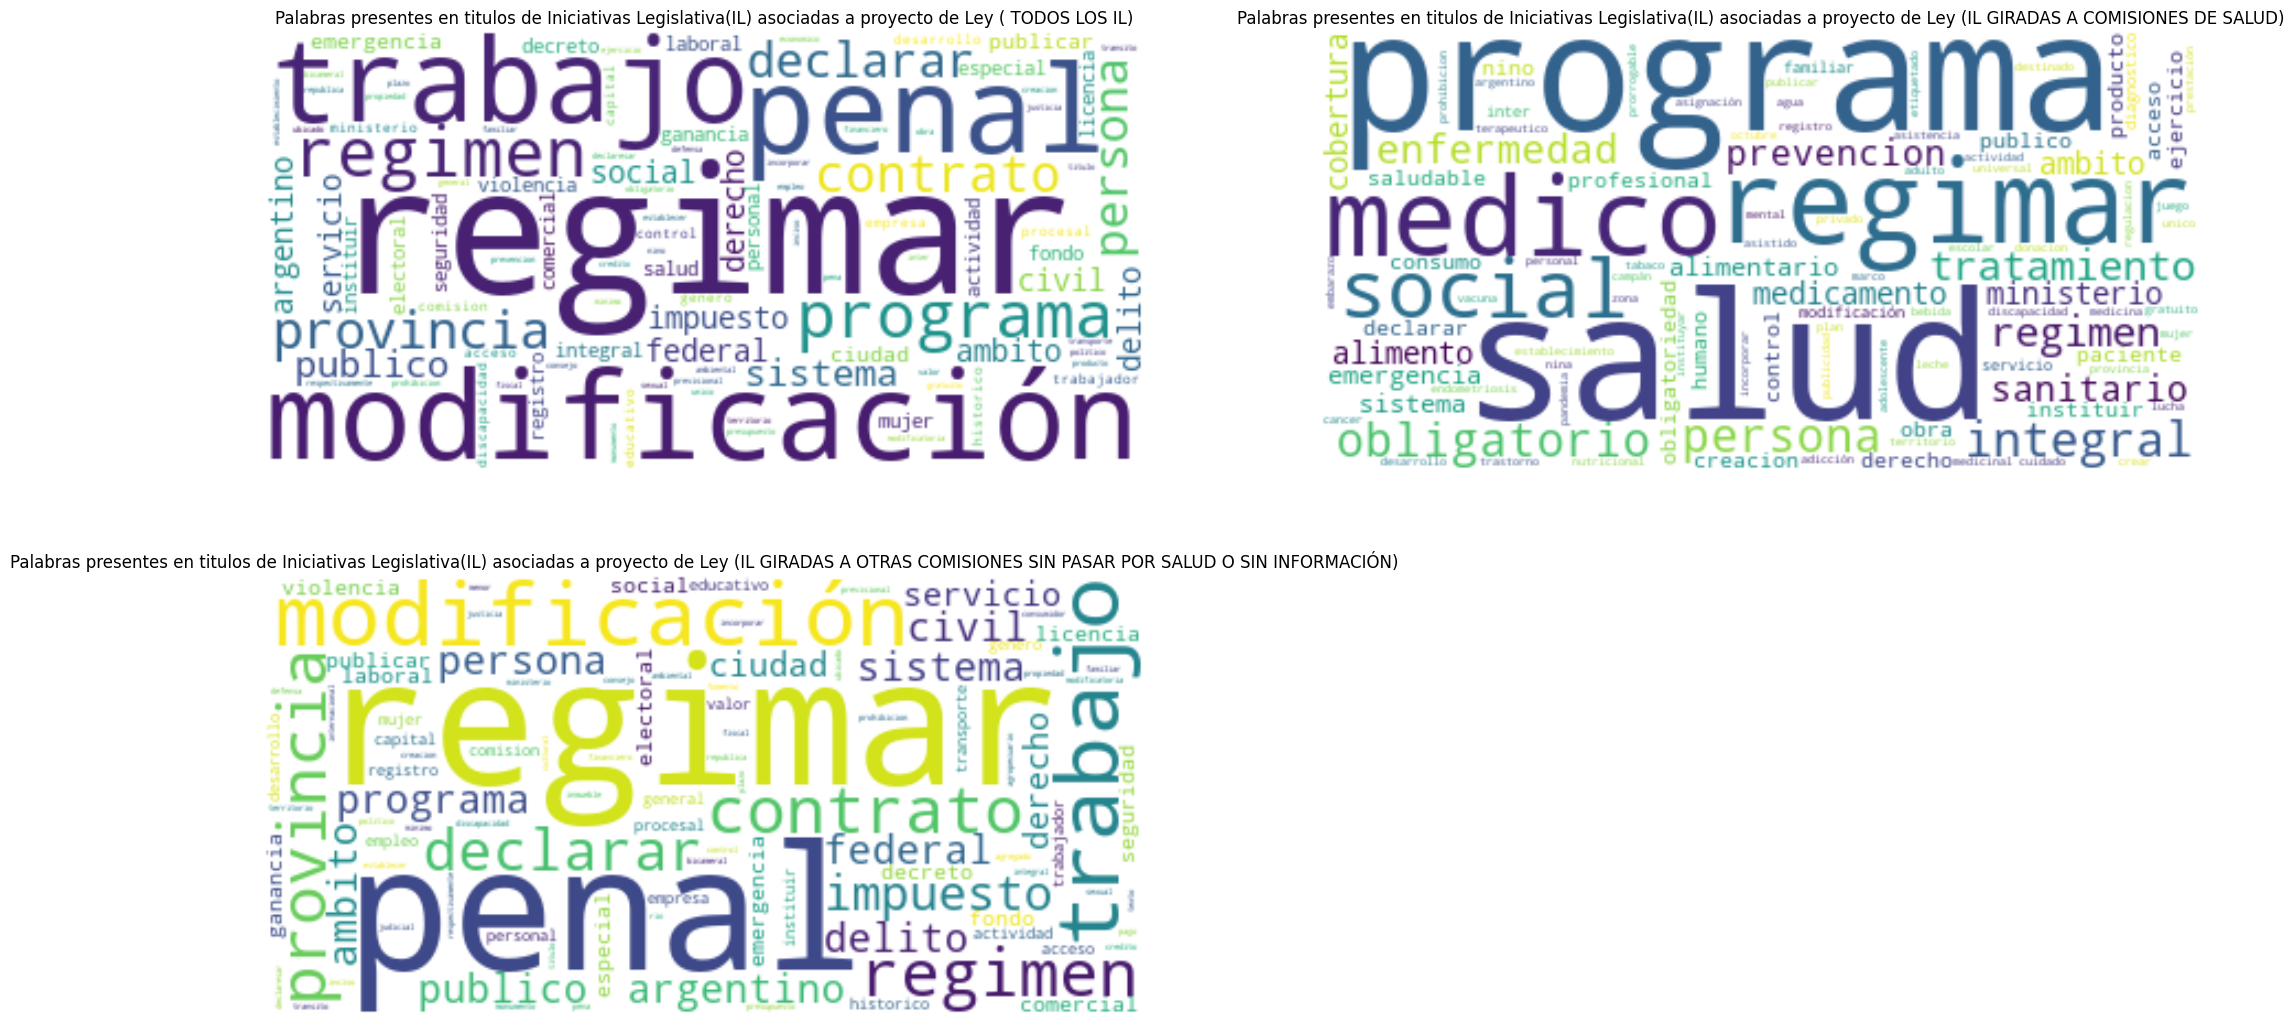

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools
%matplotlib inline


words_comisiones = {
    ' Todos los IL': dic_all,
    'IL giradas a comisiones de Salud': dic_salud,
    'IL giradas a otras comisiones sin pasar por salud o sin información':dic_otras
}

plt.figure(figsize=(25, 20))
pos = 1
for key, words in words_comisiones.items():
    plt.subplot(3, 2, pos)
    wordcloud = WordCloud(max_font_size=80, max_words=100, background_color="white").fit_words(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Palabras presentes en titulos de Iniciativas Legislativa(IL) asociadas a proyecto de Ley ({})".format(key.upper()))
    pos += 1
plt.show()



In [41]:
texto_df[texto_df['titulo normalizado']=='regimar'].head(10)

,proyecto_id,titulo,titulo normalizado,cant_token,cant_token_normalizado
12118,HCDN256091,CIBERPROTECCION. REGIMEN,regimar,2,1
21071,HCDN242027,TELEMEDICINA. REGIMEN.,regimar,2,1
22071,HCDN240563,TELEMEDICINA. REGIMEN.,regimar,2,1
22083,HCDN240552,TELEMEDICINA. REGIMEN.,regimar,2,1
28571,HCDN229589,PREADOPCION. REGIMEN.,regimar,2,1
34890,HCDN213090,GESTACION POR SUSTITUCION. REGIMEN.,regimar,4,1
41818,HCDN194914,PREADOPCION. REGIMEN.,regimar,2,1
42079,HCDN194011,PROMOCION DEL MANI. REGIMEN.,regimar,4,1
44180,HCDN190090,GESTACION POR SUSTITUCION. REGIMEN.,regimar,4,1
48631,HCDN181810,PREADOPCION. REGIMEN.,regimar,2,1
